Train a neural network to classify 1-second snippets of audio. Point it to a dataset with the following directory structure:

 dataset<br/>
 |-class_1<br/>
 |---test<br/>
 |---train<br/>
 |---validation<br/>
 |-class_2<br/>
 |---test<br/>
 |---train<br/>
 |---validation<br/>
 and so on<br/>

To install librosa in Anaconda
```
conda install -c conda-forge ffmpeg
conda install -c conda-forge librosa
```

In [1]:
#!python -m pip install sounddevice
#!python -m pip install seaborn
#!python -m pip install pandas

In [2]:
from os import listdir
from os.path import isdir, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sounddevice as sd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, backend
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import seaborn as sn
import math
from scipy.io import wavfile
from scipy import signal
import timeit

In [3]:
# Print versions
!python --version
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

Python 3.7.7
Numpy 1.18.5
TensorFlow 2.2.0
Keras 2.3.0-tf


In [4]:
# Limit GPU memory growth:
# https://github.com/tensorflow/tensorflow/issues/25160
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [40]:
# Settings (some of the many hyperparameters)
dataset_path = 'C:\\Users\\sgmustadio\\Documents\\Python\\datasets\\hadouken_set'
train_dir = 'train'
val_dir = 'validation'
test_dir = 'test'

# Files to save
keras_model_name = 'hadouken_model_03'  # Will be given .h5 suffix
sample_file_name = 'hadouken_samples_03'   # Will be given .npz suffix

# Training hyperparameters
num_folds = 10          # Number of k-fold splits (for k-fold training)
num_train = 20          # Number of times to recreate and train model to look for best F1 score
optimizer = 'adam'      # Optimizer algorithm to use
loss_function = 'sparse_categorical_crossentropy'
num_epochs = 200
batch_size = 100

# Sound sampling, filtering, and FFT parameters
sample_time = 1.0       # Sec
sample_rate = 16000     # Sample rate of samples (Hz)
resample_rate = 8000    # Downsample to this rate (Hz)
filter_cutoff = 4000    # Remove frequencies above this threshold (Hz)
stft_n_fft = 512        # Number of FFT bins (also, number of samples in each slice)
stft_n_hop = 400        # Distance between start of each FFT slice (number of samples)
                        # Make hop length multiple of sample_rate for faster sounddevice
stft_window = 'hanning' # "The window of choice if you don't have any better ideas"
stft_min_bin = 1        # Lowest bin to use (inclusive; filter out DC)  
stft_avg_bins = 8       # Number of bins to average together to reduce FFT size
shift_n_bits = 3        # Number of bits to shift 16-bit STFT values to make 8-bit values (before clipping)

# Calculated parameters
stft_n_slices = int(math.ceil(((sample_time * resample_rate) / stft_n_hop) - (stft_n_fft / stft_n_hop)) + 1)
stft_max_bin = int((stft_n_fft / 2) / ((resample_rate / 2) / filter_cutoff)) + 1

print('N slices:', stft_n_slices)
print('STFT max bin:', stft_max_bin)

N slices: 20
STFT max bin: 257


In [41]:
# Print iterations progress
# From: https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [42]:
# Figure out the labels based on folder names
labels = listdir(dataset_path)
print(labels)

['hadouken', 'other', 'silence']


In [43]:
# Create list of filenames and labels for training set
train_paths = []
train_labels = []
for i, label in enumerate(labels):
    for filename in listdir(join(dataset_path, label, train_dir)):
        train_paths.append(join(dataset_path, label, train_dir, filename))
        train_labels.append(i)
print('Number of training samples:', len(train_labels))

Number of training samples: 19472


In [44]:
# Create list of filenames and labels for validation set
val_paths = []
val_labels = []
for i, label in enumerate(labels):
    for filename in listdir(join(dataset_path, label, val_dir)):
        val_paths.append(join(dataset_path, label, val_dir, filename))
        val_labels.append(i)
print('Number of validation samples:', len(val_labels))

Number of validation samples: 2767


In [45]:
# Create list of filenames and labels for test set
test_paths = []
test_labels = []
for i, label in enumerate(labels):
    for filename in listdir(join(dataset_path, label, test_dir)):
        test_paths.append(join(dataset_path, label, test_dir, filename))
        test_labels.append(i)
print('Number of test samples:', len(test_labels))

Number of test samples: 5568


In [46]:
# Function Zip, shuffle, unzip sets
def shuffle_set(paths, labels):
    zipped_set = list(zip(paths, labels))
    random.shuffle(zipped_set)
    paths, labels = zip(*zipped_set)
    return paths, labels

In [47]:
# Shuffle sets
train_paths, train_labels = shuffle_set(train_paths, train_labels)
val_paths, val_labels = shuffle_set(val_paths, val_labels)
test_paths, test_labels = shuffle_set(test_paths, test_labels)

In [132]:
# Function: resample waveform, create compressed STFT
def calc_comp_stft(waveform, fs):
    
    # Downsample (warning: no decimation filter)
    num_samples = int((len(waveform) / fs) * resample_rate)
    waveform = signal.resample(waveform, num_samples)
    
    # Create hanning window and empty STFT buffer
    hann_window = np.hanning(stft_n_fft)
    stft = np.zeros(((stft_max_bin - stft_min_bin) // stft_avg_bins, stft_n_slices))
    for i in range(stft.shape[1]):
    
        # Get window
        win_start = i * stft_n_hop
        win_stop = (i * stft_n_hop) + stft_n_fft

        # Pad 0s if window isn't long enough
        window = waveform[win_start:win_stop]
        if len(window) < stft_n_fft:
            window = np.append(window, np.zeros((stft_n_fft - len(window),1)))

        # Get hanning window and find FFT
        window = hann_window * window
        fft = np.abs(np.fft.rfft(window, n=stft_n_fft))

        # Only keep the frequency bins we care about (i.e. filter out unwanted frequencies)
        fft = fft[stft_min_bin:stft_max_bin] # With fs=8kHz, Nyquist is 4kHz

        # Adjust for quantization and scaling in 16-bit fixed point FFT
        fft = np.around(fft / stft_n_fft)

        # Average every <stft_avg_bins bins> together to reduce size of FFT
        fft = np.mean(fft.reshape(-1, 8), axis=1)

        # Reduce precision by converting to 8-bit unsigned values [0..255]
        fft = np.around(fft / (2 ** shift_n_bits))
        fft = np.clip(fft, a_min=0, a_max=255)

        # Put FFT slide into STFT
        stft[:,i] = fft
    
    return stft

In [133]:
# Function: load file, play it, draw waveform, draw spectrogram
def analyze_clip(file_path):
    
    # Load file
    fs, waveform = wavfile.read(file_path)
    
    # Test playing it
    sd.play(waveform, fs)
    
    # Convert floating point wav data (-1.0 to 1.0) to 16-bit PCM
    waveform = np.around(waveform * 32767)
    
    # Draw time domain signal
    plt.figure()
    plt.plot(waveform)
    plt.title('Wave form (time domain)')
    
    # Calculate STFT
    _, _, stft = np.abs(signal.stft(waveform, 
                                     fs=fs, 
                                     window='hann', 
                                     nperseg=stft_n_fft,
                                     noverlap=stft_n_fft - stft_n_hop,
                                     nfft=stft_n_fft,
                                     return_onesided=True,
                                     boundary=None,
                                     padded=False))

    # Plot full spectrogram
    plt.figure(figsize=(8, 4))
    plt.imshow(stft, cmap='inferno', origin='lower', aspect='auto')
    plt.title('Full STFT')
    
    # Use manual method to create compressed STFT
    stft = calc_comp_stft(waveform, fs)
    
    # Print information about clip
    print(file_path)
    print('Waveform shape:', waveform.shape)
    print('Compressed STFT shape:', stft.shape)
    
    # Draw spectrogram
    plt.figure(figsize=(8, 4))
    plt.imshow(stft, cmap='inferno', origin='lower')
    plt.title('Compressed STFT')
    
    return stft

Label: other
C:\Users\sgmustadio\Documents\Python\datasets\hadouken_set\other\train\47056de2.wav
Waveform shape: (16000,)
Compressed STFT shape: (32, 20)


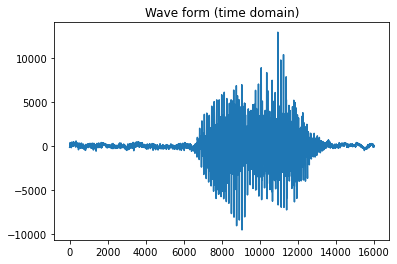

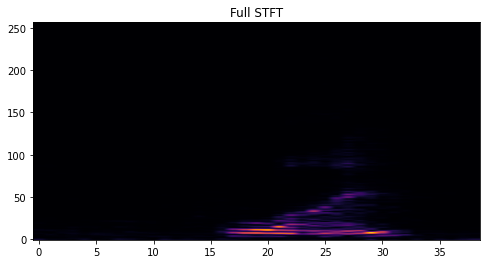

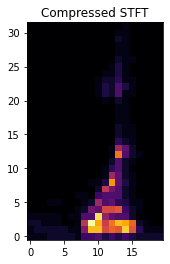

In [134]:
# Analyze a clip
num_clip = 0
print('Label:', labels[train_labels[num_clip]])
stft = analyze_clip(train_paths[num_clip])
#plt.figure()
#plt.plot(stft[:,7])

In [101]:
# Function: Read each file, create compressed STFT, keeping only ones of desired length
def extract_features(in_files, in_y, print_progress=False):
    prob_cnt = 0
    out_x = []
    out_y = []
    
    if print_progress:
        printProgressBar(0, len(in_files), prefix='Progress:', suffix='Complete', length=50)
    
    for index, path in enumerate(in_files):
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue
        
        # Load .wav file
        fs, waveform = wavfile.read(path)
        
        # Convert to something that approximates a 16-bit PCM waveform
        waveform = np.around(waveform * 32767)
        
        # Create the features (compressed STFT)
        stft = calc_comp_stft(waveform, fs)
        
        # Only keep STFTs with given length
        if stft.shape[1] == stft_n_slices:
            out_x.append(stft)
            out_y.append(in_y[index])
        else:
            #print('Dropped:', index, stft_comp.shape)
            prob_cnt += 1
        
        # Update progress bar
        if print_progress:
            printProgressBar(index + 1, len(in_files), prefix='Extracting:', suffix='Complete', length=50)
            
    return out_x, out_y, prob_cnt

In [102]:
# Create training, validation, and test sets
print('Extracting features from training set...')
x_train, y_train, prob_cnt = extract_features(train_paths, train_labels, True)
print('Removed percentage:', prob_cnt / len(train_labels))
print('Extracting features from validation set...')
x_val, y_val, prob_cnt = extract_features(val_paths, val_labels, True)
print('Removed percentage:', prob_cnt / len(train_labels))
print('Extracting features from test set...')
x_test, y_test, prob_cnt = extract_features(test_paths, test_labels, True)
print('Removed percentage:', prob_cnt / len(test_labels))

Extracting features from training set...
Extracting: |██████████████████████████████████████████████████| 100.0% Complete
Removed percentage: 0.0
Extracting features from validation set...
Extracting: |██████████████████████████████████████████████████| 100.0% Complete
Removed percentage: 0.0
Extracting features from test set...
Extracting: |██████████████████████████████████████████████████| 100.0% Complete
Removed percentage: 0.0


In [103]:
# Convert feature sets to numpy tensors
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

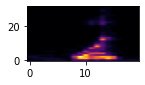

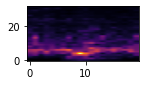

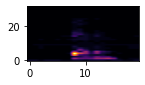

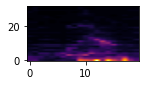

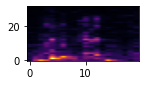

In [104]:
# Test to make sure the features are correct (and not all the same)
for i in range(0,5):
    plt.figure(figsize=(2,1))
    plt.imshow(x_train[i], cmap='inferno', origin='lower', aspect='auto')

In [105]:
# View tensor dimensions
print('Training samples:\t', x_train.shape)
print('Validation samples:\t', x_val.shape)
print('Test samples:\t\t', x_test.shape)
print('Training truth set:\t', y_train.shape)
print('Validation samples:\t', y_val.shape)
print('Test truth set:\t\t', y_test.shape)

Training samples:	 (19472, 32, 20)
Validation samples:	 (2767, 32, 20)
Test samples:		 (5568, 32, 20)
Training truth set:	 (19472,)
Validation samples:	 (2767,)
Test truth set:		 (5568,)


In [106]:
# Pick out a few samples to save
file_samples = train_paths[0:100]
x_samples = x_train[0:100]
y_samples = y_train[0:100]
print(x_samples.shape)
print(y_samples)

(100, 32, 20)
[1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 1 1 1 1 1 1 0 0 1 1
 0 1 1 1 1 1 1 2 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [107]:
# Save a few samples for testing
np.savez(sample_file_name + '.npz', file_samples=file_samples, x_samples=x_samples, y_samples=y_samples)

In [108]:
# Input shape for CNN is size of STFT of 1 sample
sample_shape = x_train.shape[1:]
print(sample_shape)

(32, 20)


In [109]:
# Function to get false positive and false negative rates from a confusion matrix
def get_fpr_fnr(cm, idx):
    fpr = np.sum(np.delete(cm[:, idx], idx)) / np.sum(cm[:, idx])
    fnr = np.sum(np.delete(cm[idx, :], idx)) / np.sum(cm[idx, :])
    return fpr, fnr

In [110]:
def get_f1_score(cm, idx):
    precision = cm[(idx, idx)] / np.sum(cm[:, idx])
    recall = cm[(idx, idx)] / np.sum(cm[idx, :])
    f1_score = 2 * (precision * recall) / (precision + recall)
    if math.isnan(f1_score):
        return 0.0
    return f1_score

In [119]:
# Function to build our model
def build_model():
    
    # OG model we started with
    model = models.Sequential([
        
        # Reshape input
        layers.InputLayer(input_shape=sample_shape),
        layers.Reshape(target_shape=(sample_shape + (1,))),
        
        # Convolutional layer
        layers.Conv2D(filters=30, kernel_size=(5, 5), activation=tf.nn.relu),
        layers.Dropout(0.5),
        layers.MaxPooling2D(pool_size=(12, 12), padding='same'),
        
        # Flatten
        layers.Flatten(),
        
        # Classifier
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(labels), activation=tf.nn.softmax)
    ])

#     # TinyML Book Model
#     model = models.Sequential([
#         layers.InputLayer(input_shape=sample_shape),
#         layers.Reshape(target_shape=(sample_shape + (1,))),
#         layers.Conv2D(filters=8, kernel_size=(10, 8), activation=tf.nn.relu),
#         layers.Dropout(0.5),
#         layers.Flatten(),
#         layers.Dense(len(labels), activation=tf.nn.softmax)
#     ])
    
    # Edge Impulse model
#     model = models.Sequential([
#         layers.InputLayer(input_shape=sample_shape),
#         layers.Reshape(target_shape=(sample_shape[0], sample_shape[1])),
#         layers.Conv1D(30, kernel_size=4, activation='relu'),
#         layers.MaxPooling1D(pool_size=4, padding='same'),
#         layers.Conv1D(10, kernel_size=4, activation='relu'),
#         layers.MaxPooling1D(pool_size=4, padding='same'),
#         layers.Flatten(),
#         layers.Dense(len(labels), activation='softmax')
#     ])
    
    # OG model we started with
#     model = models.Sequential([
#         layers.InputLayer(input_shape=sample_shape),
#         layers.Reshape(target_shape=(sample_shape + (1,))),
#         layers.Conv2D(filters=30, kernel_size=(5, 5), activation=tf.nn.relu),
#         layers.MaxPooling2D(pool_size=(5, 5), padding='same'),
#         layers.Conv2D(filters=10, kernel_size=(5, 5), activation=tf.nn.relu),
#         layers.MaxPooling2D(pool_size=(5, 5), padding='same'),
#         layers.Flatten(),
#         layers.Dense(len(labels), activation=tf.nn.softmax)
#     ])
    return model

In [120]:
# Reconstruct the model
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 32, 20, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 16, 30)        780       
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 16, 30)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 2, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 180)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                5792      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)               

In [121]:
# Ze train!
model.compile(optimizer=optimizer,
          loss=loss_function,
          metrics=['acc'])
history = model.fit(x_train,
                    y_train, 
                    epochs=50, #num_epochs, 
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_val, y_val))

Epoch 1/50
195/195 [==============================] - 1s 6ms/step - loss: 0.7482 - acc: 0.7912 - val_loss: 0.5061 - val_acc: 0.8352
Epoch 2/50
195/195 [==============================] - 1s 5ms/step - loss: 0.4773 - acc: 0.8308 - val_loss: 0.4082 - val_acc: 0.8525
Epoch 3/50
195/195 [==============================] - 1s 5ms/step - loss: 0.4201 - acc: 0.8474 - val_loss: 0.3953 - val_acc: 0.8645
Epoch 4/50
195/195 [==============================] - 1s 5ms/step - loss: 0.3753 - acc: 0.8631 - val_loss: 0.3603 - val_acc: 0.8648
Epoch 5/50
195/195 [==============================] - 1s 5ms/step - loss: 0.3580 - acc: 0.8676 - val_loss: 0.3596 - val_acc: 0.8742
Epoch 6/50
195/195 [==============================] - 1s 5ms/step - loss: 0.3395 - acc: 0.8748 - val_loss: 0.3339 - val_acc: 0.8901
Epoch 7/50
195/195 [==============================] - 1s 5ms/step - loss: 0.3295 - acc: 0.8780 - val_loss: 0.3413 - val_acc: 0.8858
Epoch 8/50
195/195 [==============================] - 1s 5ms/step - loss: 0.

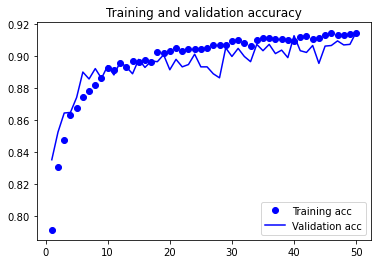

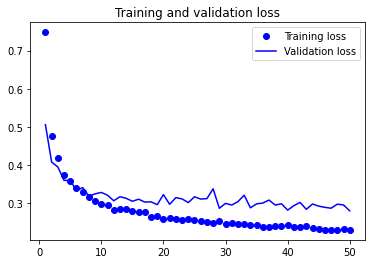

In [122]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [123]:
# Evaluate model on validation set
predictions = model.predict(x_val)
y_hat = [np.argmax(prediction) for prediction in predictions]
correct_list = (np.array(y_hat) == val_labels) * 1
print('Validation set accuracy:', np.sum(correct_list) / len(correct_list))

Validation set accuracy: 0.9150704734369353


In [124]:
# Make confusion matrix
cm = confusion_matrix(val_labels, y_hat)
print(cm)

[[ 233   91    0]
 [  21 2241    6]
 [   0  117   58]]


Text(33.0, 0.5, 'Actual')

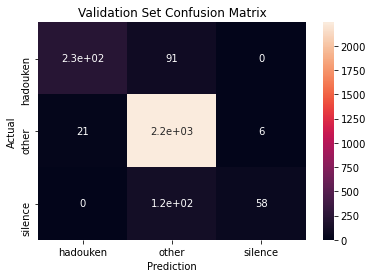

In [125]:
# Make confusion matrix pretty
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure()
sn.heatmap(df_cm, annot=True)
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [126]:
# Show accuracy of target word
target_idx = 0
fpr, fnr = get_fpr_fnr(cm, target_idx)

print('Target word:', labels[target_idx])
print('False positive rate:', fpr)
print('False negative rate:', fnr)
print('F1 Score:', get_f1_score(cm, target_idx))

Target word: hadouken
False positive rate: 0.08267716535433071
False negative rate: 0.2808641975308642
F1 Score: 0.8062283737024222


In [ ]:
# For realz training: do it multiple times and save the one with the lowest validation FP/FN combination
best_model = None
best_f1_score = 1.0
target_idx = 0
print('Target word:', labels[target_idx])

# Try taining a bunch of models and keeping the best one
for i in range(num_train):
    
    # Keep track of which loop we're on
    print('Starting training loop', i)
    print('')
    
    # Create model (need to do this every time to re-initialize random weights)
    model = build_model()
    
    # Ze train!
    model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['acc'])
    history = model.fit(x_train,
                        y_train, 
                        epochs=num_epochs, 
                        batch_size=batch_size,
                        verbose=0,
                        validation_data=(x_val, y_val))
    
    # Evaluate model on validation set
    predictions = model.predict(x_val)
    y_hat = [np.argmax(prediction) for prediction in predictions]
    correct_list = (np.array(y_hat) == val_labels) * 1
    
    # Make confusion matrix
    cm = confusion_matrix(val_labels, y_hat)
    
    # Get FP/FN of target word
    fpr, fnr = get_fpr_fnr(cm, target_idx)
    
    # This seems a bit hackerish: average FPR and FNR to get one number
    f1_score = get_f1_score(cm, target_idx)
    
    # Print out metrics
    print('')
    print(cm)
    print('False positive rate:', fpr)
    print('False negative rate:', fnr)
    print('F1 score:', f1_score)
    print('')
    print('------------------------------------------------------------------------')
    
    # Compare to best score and save model of best score
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_model = model
        
print('')
print('Done!')
print('Best score:', best_f1_score)

In [127]:
# Evaluate model on test set
predictions = model.predict(x_test)
y_hat = [np.argmax(prediction) for prediction in predictions]
correct_list = (np.array(y_hat) == test_labels) * 1
print('Test set accuracy:', np.sum(correct_list) / len(correct_list))

Test set accuracy: 0.8900862068965517


In [128]:
# Make confusion matrix
cm = confusion_matrix(test_labels, y_hat)
print(cm)

[[ 411  272    0]
 [  89 4427   19]
 [   0  232  118]]


Text(33.0, 0.5, 'Actual')

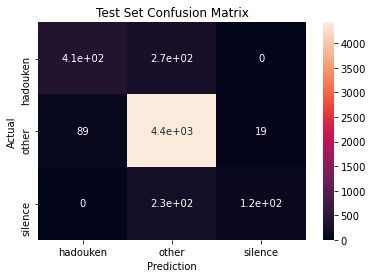

In [129]:
# Make confusion matrix pretty
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure()
sn.heatmap(df_cm, annot=True)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [130]:
# Show accuracy of target word
target_idx = 0
fpr = np.sum(np.delete(cm[:, 0], target_idx)) / np.sum(cm[:, 0])
fnr = np.sum(np.delete(cm[0, :], target_idx)) / np.sum(cm[0, :])

print('Target word:', labels[target_idx])
print('False positive rate:', fpr)
print('False negative rate:', fnr)
print('Score:', get_f1_score(cm, target_idx))

Target word: hadouken
False positive rate: 0.178
False negative rate: 0.39824304538799415
Score: 0.694843617920541


In [131]:
# If we're happy with the performance, save the model
model.save(keras_model_name + '.h5')